In [2]:
import os
import pandas as pd
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [1]:
!pip install albumentations==0.4.6

In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=4b8bf4ae8753174a1012da33adffd6bf3c7ba83089ce2c1d39f4d262edb35951
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/train.zip
!unzip /content/drive/MyDrive/test.zip

In [5]:
torch.cuda.empty_cache()

In [6]:
import random

random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [7]:
test_dir = '/content/test'
train_dir = '/content/train'

In [ ]:
image_list = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):

        image_list.append((os.path.join(train_dir,label,image),label))
train_data= np.array(image_list)

print(train_data[:10])

In [ ]:
for i in range(len(train_data)):
  if train_data[i][1] == 'dog':
    train_data[i][1] = 0
  elif train_data[i][1] =='elephant':
    train_data[i][1] = 1
  elif train_data[i][1] == 'giraffe':
    train_data[i][1]=2
  elif train_data[i][1] == 'guitar':
    train_data[i][1]=3
  elif train_data[i][1] == 'horse':
    train_data[i][1]=4
  elif train_data[i][1] == 'house':
    train_data[i][1]=5
  elif train_data[i][1] == 'person':
    train_data[i][1]=6

print(train_data[130:150])

In [10]:
train_image =[]
train_index =[]
for i in range(len(train_data)):
  train_image.append(train_data[i][0])
  train_index.append(int(train_data[i][1]))

print(train_image[:5])
print(train_index[:5])

['/content/train/horse/pic_052.jpg', '/content/train/horse/pic_164.jpg', '/content/train/horse/pic_165.jpg', '/content/train/horse/pic_085.jpg', '/content/train/horse/pic_112.jpg']
[4, 4, 4, 4, 4]


In [11]:
class TrainDataset(Dataset):
    def __init__(self, img_path,img_index, transform):
        self.img_path = img_path
        self.img_index = img_index
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_path[index])
        label = self.img_index[index]
        if self.transform:
            image = self.transform(image)
        return image,label

    def __len__(self):
        return len(self.img_path)

In [12]:
image_transform = transforms.Compose([
    Resize((227, 227), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [13]:
X_train, X_eval, y_train, y_eval  = train_test_split(train_image,train_index, test_size = 0.2)

In [27]:
trainset = TrainDataset(X_train,y_train, image_transform)
evalset = TrainDataset(X_eval,y_eval, image_transform)

train_loader = DataLoader(trainset, batch_size = 32)
val_loader = DataLoader(evalset, batch_size = 32)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        
        
model = EfficientNet.from_pretrained('efficientnet-b4')
num = model._fc.in_features
classifier = nn.Sequential(
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(num,7),
                          )
model._fc = classifier
model.apply(init_weights)
model.to(device)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        

model2 = models.resnet50(pretrained=True)
num = model2.fc.in_features
classifier2 = nn.Sequential(nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(num,7)
                          )
model2.fc = classifier2
model2.apply(init_weights)
model2.to(device)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        
        
model3 = EfficientNet.from_pretrained('efficientnet-b3')
num = model3._fc.in_features
classifier = nn.Sequential(
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(num,7),
                          )
model3._fc = classifier
model3.apply(init_weights)
model3.to(device)

<Figure size 432x216 with 0 Axes>

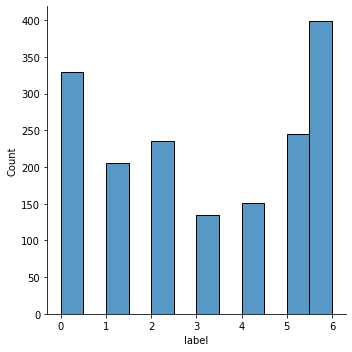

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
a = np.array(train_image)
b = np.array(train_index)

c = pd.DataFrame(a,columns=['path'])
c['label'] = pd.DataFrame(b)
c

plt.figure(figsize=(6, 3))
sns.displot(c, x="label")

In [17]:
def get_class_weight(label):
    label_unique, count = np.unique(label, return_counts=True)
    return [1-c/sum(count) for c in count]

result = get_class_weight(train_index)
result=torch.Tensor(result)
result = result.to(device)

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [19]:
import torchvision.models as models
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(weight=result)

optimizer = optim.AdamW(model3.parameters(), lr = 3e-4, weight_decay= 1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

In [25]:
def train(epochs , train_loader, val_loader , model , criterion , optimizer,lr_scheduler):
    counter = 0
    best_val_acc = 0
    best_val_loss = np.inf
    patience = 5
    
    for epoch in range(epochs):
        model.train()
        
        loss_train_sum = 0
        acc_train_sum = 0
        
        for i , (img , target) in enumerate(train_loader):
            img = img.to(device)
            target = target
            target = target.to(device, dtype=torch.int64)
            
            y_pred = model(img)
            loss = criterion(y_pred, target)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train_sum += loss
            acc_train_sum += (y_pred.argmax(1) == target).sum().item()/ 32

        loss_train_avg = loss_train_sum / len(train_loader)
        acc_train_avg = acc_train_sum / len(train_loader)
        print(f" epoch:[{epoch+1}/{epochs}] cost:[{loss_train_avg:.3f}] acc : [{acc_train_avg : .3f}]")
        
        
        model.eval()
        loss_val_sum = 0
        acc_val_sum = 0
        val_loss_items = []
        val_acc_items = []
        
        for i , (img , target) in enumerate(val_loader):
            img = img.to(device)
            target = target.to(device, dtype=torch.int64)
            
            with torch.no_grad():
                y_pred = model(img)
                loss = criterion(y_pred, target)
            
            loss_val_sum += loss
            acc_val_sum += (y_pred.argmax(1) == target).sum().item()/ 32
            val_loss_items.append(loss_val_sum)
            val_acc_items.append(acc_val_sum)
        
        
        loss_val_avg = loss_val_sum / len(val_loader)
        acc_val_avg = acc_val_sum / len(val_loader)
        
        if loss_val_avg < best_val_loss:
            best_val_loss = loss_val_avg
        if acc_val_avg > best_val_acc:
            print("New best model for val accuracy! saving the model..")
            best_val_acc = acc_val_avg
            counter = 0
        else:
            counter += 1
        if counter > patience:
            print("Early Stopping...")
            break
            
        print(f" epoch:[{epoch+1}/{epochs}] eval_cost:[{loss_val_avg:.3f}] eval_acc : [{acc_val_avg : .3f}]")
        
        lr_scheduler.step()

In [29]:
train(15 , train_loader , val_loader , model3, criterion ,optimizer,lr_scheduler)

RuntimeError: ignored

In [25]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [26]:
image_paths = glob(test_dir+'/*'+'/*')

In [ ]:
image_paths.sort()
image_paths

In [35]:
submission = pd.read_csv('/content/drive/MyDrive/test_answer_sample_.csv')

transform = transforms.Compose([
    Resize((227, 227), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

model3.eval()

all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model3(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['answer value'] = all_predictions


submission.to_csv(os.path.join(test_dir, 'ensemble3.csv'), index=False)
print('test inference is done!')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


test inference is done!


In [ ]:
def most_frequent(data):
    length = len(data)
    arr = [0 for i in range (length)]

    for i in range(length):
        for j in range(i+1, length):
            if data[i] == data[j]:
                    arr[i] += 1
    max = 0
    for i in range(length):
        for j in range(i+1, length):
            if arr[i] < arr[j]:
 
                max = j
    return data[max]

In [38]:
submission_csv1 = pd.read_csv('/content/test/ensemble1.csv',index_col = 0)
ensemble1 = list(submission_csv1['answer value'])

submission_csv2 = pd.read_csv('/content/test/ensemble2.csv',index_col = 0)
ensemble2 = list(submission_csv2['answer value'])

submission_csv3 = pd.read_csv('/content/test/ensemble3.csv',index_col = 0)
ensemble3 = list(submission_csv3['answer value'])


In [41]:
def most_frequent(data):
    length = len(data)
    arr = [0 for i in range (length)]

    for i in range(length):
        for j in range(i+1, length):
            if data[i] == data[j]:
                    arr[i] += 1
    max = 0
    for i in range(length):
        for j in range(i+1, length):
            if arr[i] < arr[j]:
 
                max = j
    return data[max]

In [44]:
final = []

for i in range(len(ensemble1)):
  data = []
  data.append(ensemble1[i])
  data.append(ensemble2[i])
  data.append(ensemble3[i])
  final.append(most_frequent(data))

submission['answer value'] = final


submission.to_csv(os.path.join(test_dir, 'final.csv'), index=False)
print('test inference is done!')

test inference is done!


In [39]:
print(ensemble1)

[2, 3, 3, 3, 3, 3, 4, 4, 3, 1, 6, 2, 6, 2, 3, 1, 2, 0, 6, 3, 3, 5, 2, 3, 0, 5, 1, 2, 0, 5, 1, 5, 6, 2, 0, 5, 5, 4, 5, 1, 4, 0, 2, 3, 1, 3, 0, 5, 5, 2, 6, 5, 4, 1, 5, 0, 4, 6, 1, 0, 5, 0, 6, 1, 1, 2, 4, 1, 1, 3, 2, 3, 0, 1, 1, 6, 2, 0, 3, 4, 1, 2, 1, 6, 6, 4, 3, 6, 1, 5, 2, 5, 1, 0, 5, 6, 3, 3, 1, 6, 5, 6, 6, 0, 3, 2, 5, 3, 0, 3, 4, 6, 2, 5, 4, 2, 0, 1, 5, 6, 4, 2, 2, 6, 4, 1, 5, 6, 0, 4, 1, 1, 6, 4, 4, 2, 5, 6, 5, 0, 4, 3, 1, 5, 1, 5, 4, 0, 2, 5, 6, 1, 6, 3, 2, 2, 0, 1, 4, 5, 2, 4, 6, 2, 3, 4, 1, 5, 6, 2, 1, 5, 3, 4, 0, 3, 2, 5, 3, 4, 2, 0, 3, 6, 0, 3, 3, 2, 0, 4, 0, 2, 2, 4, 4, 6, 6, 6, 3, 5, 5, 5, 4, 6, 2, 1, 3, 6, 0, 2, 3, 1, 1, 3, 1, 5, 2, 2, 0, 0, 6, 1, 2, 2, 6, 1, 3, 2, 5, 4, 3, 5, 0, 1, 4, 6, 0, 1, 4, 1, 6, 1, 2, 1, 6, 0, 5, 4, 6, 3, 4, 2, 5, 3, 1, 4, 2, 3, 4, 0, 6, 0, 2, 0, 1, 4, 4, 4, 0, 1, 1, 5, 6, 4, 6, 2, 4, 4, 3, 6, 6, 1, 0, 3, 5, 3, 0, 4, 5, 2, 5, 5, 2, 5, 2, 6, 5, 1, 5, 1, 5, 3, 6, 3, 3, 1, 6, 5, 0, 4, 0, 4, 3, 4, 4, 2, 5, 1, 2, 0, 6, 6, 1, 3, 3, 0, 0, 5, 2, 4, 6, 6, 6, 

In [42]:
a = [1,2,1]

In [43]:
b = most_frequent(a)
b

1